# Sentiment Analysis using RNN with LSTM

In [1]:
from collections import Counter
from datetime import datetime

import json

from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import numpy as np

C:\Users\Monas\Anaconda3\envs\deeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


To load the reviews from disk, run the following in the next cell:

In [2]:
import json
input="Filtered_review_1L.json"
with open(input, "r") as f:
    reviews = f.read().strip().split("\n")
reviews = [json.loads(review) for review in reviews]

Each review in the Yelp dataset contains the text of the review and the associated star rating, left by the reviewer. Our task is to teach a classifier to differentiate between positive and negative reviews, looking only at the review text itself.

It is very important to have a balanced dataset for supervised learning. This means that we want the same amount of positive and negative reviews when we train our neural network to tell the difference between them. If we have more positive reviews than negative reviews, the network will learn that most reviews are positive, and adjust its predictions accordingly. We’ll, therefore, take a sample of the Yelp reviews which contains the same amount of positive (four or five-star reviews) and negative (one, two, or three-star reviews).

In [3]:
text_list = [review['text'] for review in reviews]
 
# Convert our 5 classes into 2 (negative or positive)
binstars = [0 if review['stars'] <= 3 else 1 for review in reviews]
trained_texts = []
trained_labels = []
limit = 100000  # Change this to grow/shrink the dataset
neg_pos_counts = [0, 0]
for i in range(len(text_list)):
    polarity = binstars[i]
    if neg_pos_counts[polarity] < limit:
        trained_texts.append(text_list[i])
        trained_labels.append(binstars[i])
        neg_pos_counts[polarity] += 1

This gets 100000 positive and 100000 negative reviews. If we use less data, we’ll get significantly worse accuracy, as neural networks usually need a lot of data to train well. More data will result in longer training times for our neural network.

### Tokenizing the texts

Keras represents each word as a number, with the most common word in a given dataset being represented as 1, the second most common as a 2, and so on. This is useful because we often want to ignore rare words, as usually, the neural network cannot learn much from these, and they only add to the processing time. If we have our data tokenized with the more common words having lower numbers, we can easily train on only the N most common words in our dataset, and adjust N as necessary (for larger datasets, we would want a larger N, as even comparatively rare words will appear often enough to be useful).

Tokenization in Keras is a two step process. First, we need to calculate the word frequencies for our dataset (to find the most common words and assign these low numbers). Then we can transform our text into numerical tokens. The calculation of the word frequencies is referred to as ‘fitting’ the tokenizer, and Keras calls the numerical representations of our texts ‘sequences’.

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000)
 
tokenizer.fit_on_texts(trained_texts)
sequences = tokenizer.texts_to_sequences(trained_texts)
data = pad_sequences(sequences, maxlen=300)

### Creating Neural network model

One of the more complicated architectures, which is known to perform very well on text data, is the Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM). RNNs are designed to learn from sequences of data, where there is some kind of time dependency. For example, they are used for time-series analysis, where each data point has some relation to those immediately before and after. By extension, they work very well for language data, where each word is related to those before and after it in a sentence.

When we use more layers the accuracy gets slightly worse, but the execution gets there much faster.

In [5]:
model = Sequential()
model.add(Embedding(20000, 128, input_length=300))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(data, np.array(trained_labels), validation_split=0.5, epochs=3)


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Train on 50000 samples, validate on 50000 samples
Epoch 1/3
50000/50000 [==============================] - 466s 9ms/step - loss: 0.3855 - acc: 0.8318 - val_loss: 0.3258 - val_acc: 0.8665
Epoch 2/3
50000/50000 [==============================] - 449s 9ms/step - loss: 0.2632 - acc: 0.8963 - val_loss: 0.3408 - val_acc: 0.8560
Epoch 3/3
50000/50000 [==============================] - 447s 9ms/step - loss: 0.1865 - acc: 0.9302 - val_loss: 0.3522 - val_acc: 0.8591


In [25]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 128)          2560000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 296, 64)           41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 74, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,699,969
Trainable params: 2,699,969
Non-trainable params: 0
_________________________________________________________________


### Change in plateau
We are displaying the accuracy vs expected accuracy and loss with expected loss

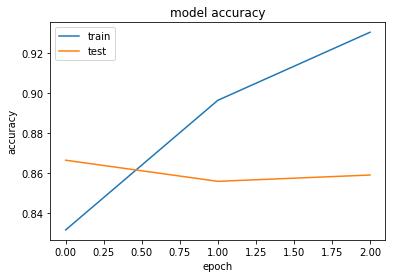

In [8]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

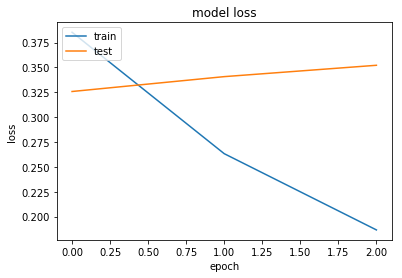

In [7]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Result
Predicting with the model with some new phrases. We will analyze it with different scenarios.

In [24]:
newtexts = ["Awesome", "Rotten", "OMG", "Not good", "Murdered here. Would not recommend"]
 
sequences = tokenizer.texts_to_sequences(newtexts)
data = pad_sequences(sequences, maxlen=300)
 
predictions = model.predict(data)
print(predictions*100)

[[94.092064]
 [37.70201 ]
 [95.37676 ]
 [31.130424]
 [15.367164]]


Here we are passing some new data to check if our trained model is working fine. This can be easily done by creating a dictionary with new works and passing that to our model to predict. Our result will be negative to positive when we go from 0 to 100.
We analyzed for different scenarios:
1. Positive
2. Negative
3. Sarcasm
We see that the prediction is fair enough and justifies our model.